In [1]:
import numpy as np
import autograd_objective
from poisson_id_link_model import Problem, Sim, fit, XObjEstimator, MAPEstimator
from evaluate_errors import Evaluate, NullaryEstimator

## Overview

We're modelling particle counts at $k$ detectors, caused by an event in a space X, discretized as $X^m$.

We assume that we can model a count at a detector $y_i$ as a Poisson distribution dependent on an event vector $x^m$,

$$
y_i \sim Poisson(\lambda_i)
$$

$$
\lambda_i = \alpha_i \cdot x^m + \beta_i = \theta_i \cdot x^m
$$

where:
* the $x^m$ vectors are sparse; they correspond to a point event
* the structure of $\theta_i$ is not clear

For example, say we've got 3 detectors, and we've discretized the space where decomposition events happen into $m=4$ cells.

The Poisson means $\lambda_i$ are given by

$$
\left[
\begin{matrix} 
\lambda_0 \\
\lambda_1 \\
\lambda_2 \\
\end{matrix}
\right]
=
\left[
\begin{matrix} 
\alpha_{00} & \alpha_{01} & \alpha_{02} & \alpha_{03} & \beta_0 \\
\alpha_{10} & \alpha_{11} & \alpha_{12} & \alpha_{13} & \beta_1 \\
\alpha_{20} & \alpha_{21} & \alpha_{22} & \alpha_{23} & \beta_2 \\
\end{matrix}
\right]
\cdot
\left[
\begin{matrix} 
x_0 \\
x_1 \\
x_2 \\
x_3 \\
1 \\
\end{matrix}
\right]
$$


This seems intuitive to me; an event in a given cell causes Poisson-distributed counts in a given detector; the dark count rate is taken care of by $\beta$; rates are linear in the events.

So we have 2 problems.

* Estimate the parameter vector $\theta$ given training data $(x, y)$: We have training tuples (presumably from the geant4 simulation) and we use them to estimate the $\theta$ coefficients.
* Given an experimental measurement of $y$ and a precalculated $\theta$, recover $x$


### Problem characterization

Our problems are characterized by:
* the number of detectors $y\_dim$
* the number of discretized space voxels $x\_dim$

so let's come up with a dummy problem and try to recover $\theta$.

In [2]:
theta = 10 * np.array([
    [1.0, 0.5, 0.1, 0.1, 0.01],
    [0.5, 0.1, 1.0, 0.1, 0.01],
    [0.1, 1.0, 0.5, 0.1, 0.3], # this one's dcr is high
])
sim = Sim(theta)
xs, ys, eys = [], [], []
for i in range(100000):
    x, y = sim.sample()
    e_y = sim.obj.Ey_given_x(sim.theta, x)
    ys.append(y)
    eys.append(e_y)
    
# quick sanity check
print(np.mean(ys, axis = 0) - np.mean(eys, axis = 0))


[0.00497 0.00678 0.00193]


Proof of concept solver:
* I'm being really braindead about it, not taking advantage of the sparsity of $x$ to get a quadratic speed up and give the solver an easier time
* I'm using the scipy [trust-constr solver](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-trustconstr.html) because we have a nonnegativity constraint
* I'm also using [autograd](https://github.com/HIPS/autograd) because it's super easy to get the gradient and I can use the built-in hessian vector product to give the solver second-order information (not that I know if it matters)

There must be a specialized solver for this somewhere, maybe in [cvxopt](https://cvxopt.org/) or in [The Bible](https://web.stanford.edu/~boyd/cvxbook/), but I try not to look at the Boyd & Vandenberghe book for too long because it makes my brain hurt.

In [3]:
train_xs_100, train_ys_100 = sim.sample_n(100)
obj = autograd_objective.ThetaObjective(train_xs_100, train_ys_100)
theta_100, _sol = fit(obj)
frobenius_100 = np.linalg.norm(theta - theta_100, ord="fro")

Let's give it more samples and see if the frobenius norm $\| \theta - \hat{\theta} \|_{\rm F}$ goes down as expected as the number of samples goes up:

In [4]:
train_xs_1000, train_ys_1000 = sim.sample_n(1000)
obj = autograd_objective.ThetaObjective(train_xs_1000, train_ys_1000)
theta_1000, _sol = fit(obj)
frobenius_1000 = np.linalg.norm(theta - theta_1000, ord="fro")
print('frobenius 100: {0} 1000: {1}'.format(frobenius_100, frobenius_1000))

frobenius 100: 2.172607905191046 1000: 0.6659851520749372


## Finding x

Engineering beats cleverness, so let's start with a framework that lets us easily evaluate our estimators.

We can start from a baseline *nullary* estimator; this simply draws samples from the marginal x distribution; it's simply a random guess consistent with the marginal x distribution.

If we can't beat this, we're screwed.

We'll evaluate 2 approaches.

### MAP estimator

This relies on assuming either 0 or 1 decomposition events happen per time slice.

If our event space has been discretized into $m$ cells, we have $m + 1$ alternative hypotheses $H = \{\overrightarrow{0}, \overrightarrow{e_1}, \overrightarrow{e_2}, \ldots, \overrightarrow{e_m}\}$ for each time slice that can explain the detector measurements: the unit vectors in $R^m$ and the $0^m$ vector.

So if we have a function proportional to the likelihood $l(x^m \mid \theta, y)$ implied by our Poisson model, we're looking for

$$
\underset{x^m \in H}{\text{argmax}} \, l(x^m \mid \theta, y)
$$

We get an easy $l$ function if we assume indepedence between detectors and simply multiply their likelihoods together, and assume a uniform prior on the hypotheses $h_i$

### Minimize $x^m$

We can minimize $x^m$ if we have the likelihood $l(x^m \mid \theta, y)$ ; in this toy problem we're not putting a prior on $x^m$ but this is where the l1 penalty might come in handy in the real case.

This method has the advantage that it can handle cases where more than 0 or 1 events are likely in a given time slice, and more.

## Let's try the different approaches

The first time around there was weirdness because there was too little power; there were an expected number of 5.4 photons counted per sample and that was insufficient. I upped the power a bit:

In [5]:
theta.sum()

54.2

and now things are easier for the solver.

I understand there's like several hundred expected photons in the real deal.

In [6]:
test_xs, test_ys = sim.sample_n(100)
nullary_estimator = NullaryEstimator(sim)
map_estimator = MAPEstimator('MAP', theta)
xobj_estimator = XObjEstimator('XObj', theta)
xobj_estimator_100 = XObjEstimator('XObj_100', theta_100)

evaluator = Evaluate([nullary_estimator, map_estimator, xobj_estimator_100, xobj_estimator], test_xs, test_ys)

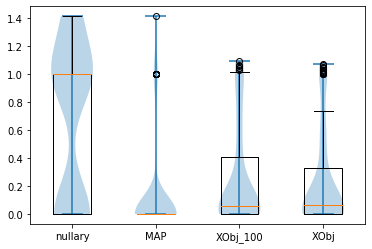

In [7]:
evaluator.boxplot()

This looks reasonable; 100 samples in these conditions suffice to make XObj_100 almost as good as XObj.